This is our recreation of Lehtinen et al.'s paper "Noise2Noise". 

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import keras
from importlib import reload

In [2]:
from helpers import generators, utils, noise_models
from models import unet_n2n, irfan_2020

In [3]:
reload(utils)
reload(noise_models)

<module 'helpers.noise_models' from '/Users/antrikshdhand/Documents/github/thesis-ml/ml/main/helpers/noise_models.py'>

In [4]:
np.random.seed(42)

## Initialise data

In [5]:
TRAIN_IMAGE_DIR = "../../raw_datasets/imagenet-10k"
VAL_IMAGE_DIR = "../../raw_datasets/BSDS300/images/train"
TEST_IMAGE_DIR = "../../raw_datasets/BSDS300/images/test"

NUM_EPOCHS = 50
GPU_BATCH_SIZE = 4
DATA_BATCH_SIZE = 16

In [6]:
noise_model = noise_models.gaussian_noise

In [7]:
training_gen = generators.NoisyImageTrainGenerator(
    image_dir=TRAIN_IMAGE_DIR,
    input_noise_model=noise_model,
    target_noise_model=noise_model,
    batch_size=DATA_BATCH_SIZE,
    patch_edge_size=192,
    zero_one_normalisation=True,
    greyscale=True
)

validation_gen = generators.NoisyImageValGenerator(
    image_dir=VAL_IMAGE_DIR,
    noise_model=noise_model,
    batch_size=DATA_BATCH_SIZE,
    patch_edge_size=192,
    zero_one_normalisation=True,
    greyscale=True
)

test_gen = generators.NoisyImageValGenerator(
    image_dir=TEST_IMAGE_DIR,
    noise_model=noise_model,
    batch_size=DATA_BATCH_SIZE,
    patch_edge_size=192,
    zero_one_normalisation=True,
    greyscale=True
)

## Initialise model

In [8]:
model = irfan_2020.get_irfan_model(input_shape=(192, 192, 1))
# model = unet_n2n.get_unet_model(input_shape=(192, 192, 1))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.99, epsilon=1e-8),
    loss=keras.losses.MeanSquaredError(),
    metrics=[utils.psnr],
)

model.summary()

2024-12-07 00:48:03.584541: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-07 00:48:03.584581: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-07 00:48:03.584585: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-07 00:48:03.584920: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-07 00:48:03.585013: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "irfan_2020"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 192, 192, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 64)      640       
                                                                 
 activation (Activation)     (None, 192, 192, 64)      0         
                                                                 
 batch_normalization (Batch  (None, 192, 192, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        3

## Train model

In [9]:
csv_logger = keras.callbacks.CSVLogger(
    filename="models/saved/n2n_imagenet10k_05122024/irfan/training.log",
    separator=',',
    append=False
)

backup_callback = keras.callbacks.BackupAndRestore(
    backup_dir="models/saved/n2n_imagenet10k_05122024/irfan/tmp"
)

In [10]:
history = model.fit(
    training_gen,
    validation_data=validation_gen,
    batch_size=GPU_BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=2,
    callbacks=[csv_logger, backup_callback]
)

Epoch 1/50


2024-12-07 00:48:04.545689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-07 00:50:38.687349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 - 155s - loss: 0.0369 - psnr: 14.8934 - val_loss: 0.0166 - val_psnr: 18.5121 - 155s/epoch - 249ms/step
Epoch 2/50
625/625 - 155s - loss: 0.0282 - psnr: 16.0634 - val_loss: 0.0129 - val_psnr: 19.7413 - 155s/epoch - 247ms/step
Epoch 3/50
625/625 - 155s - loss: 0.0265 - psnr: 16.3790 - val_loss: 0.0119 - val_psnr: 20.2920 - 155s/epoch - 247ms/step
Epoch 4/50
625/625 - 155s - loss: 0.0257 - psnr: 16.5435 - val_loss: 0.0123 - val_psnr: 20.1220 - 155s/epoch - 248ms/step
Epoch 5/50
625/625 - 155s - loss: 0.0246 - psnr: 16.7551 - val_loss: 0.0112 - val_psnr: 20.4933 - 155s/epoch - 249ms/step
Epoch 6/50
625/625 - 155s - loss: 0.0244 - psnr: 16.8087 - val_loss: 0.0113 - val_psnr: 20.3302 - 155s/epoch - 248ms/step
Epoch 7/50
625/625 - 155s - loss: 0.0239 - psnr: 16.9139 - val_loss: 0.0117 - val_psnr: 20.3399 - 155s/epoch - 248ms/step
Epoch 8/50
625/625 - 155s - loss: 0.0237 - psnr: 16.9712 - val_loss: 0.0103 - val_psnr: 20.9136 - 155s/epoch - 248ms/step
Epoch 9/50
625/625 - 155s - loss: 0

In [11]:
model.save("models/saved/n2n_imagenet10k_05122024/irfan/50epochs.keras")
# model.save("models/saved/n2n_imagenet10k_05122024/unet/50epochs.keras")

/var/folders/6d/6rll4yfx64n5s_34fjy87zd80000gn/T/ipykernel_21052/3385282390.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  together.show()


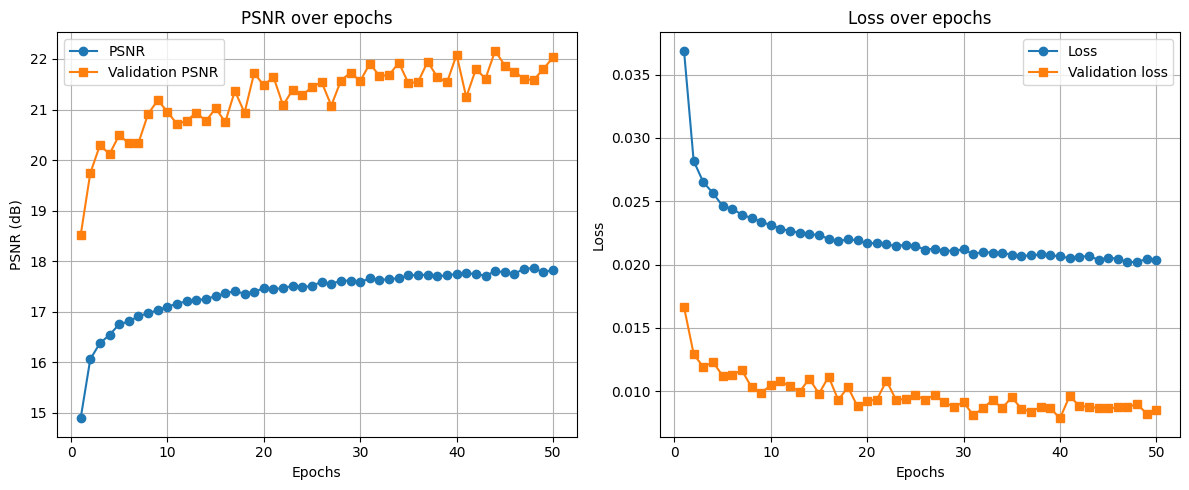

In [12]:
reload(utils)

together = utils.get_psnr_and_loss_curves(history, together=True)
together.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/psnr_loss.pdf')
# together.savefig('models/saved/n2n_imagenet10k_05122024/unet/img/psnr_loss.pdf')
together.show()


## Evaluate model

In [13]:
evals = model.evaluate(
    test_gen,
    batch_size=GPU_BATCH_SIZE,
    verbose=2
)

6/6 - 0s - loss: 0.0080 - psnr: 22.1532 - 282ms/epoch - 47ms/step


In [14]:
evals

[0.00802950095385313, 22.153175354003906]

1/1 [==============================] - 0s 31ms/step


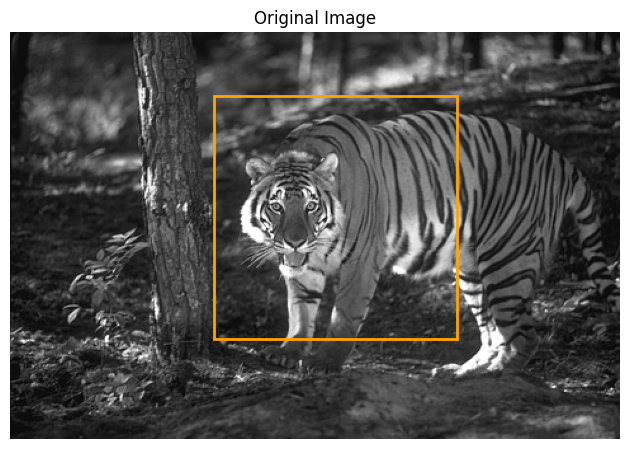

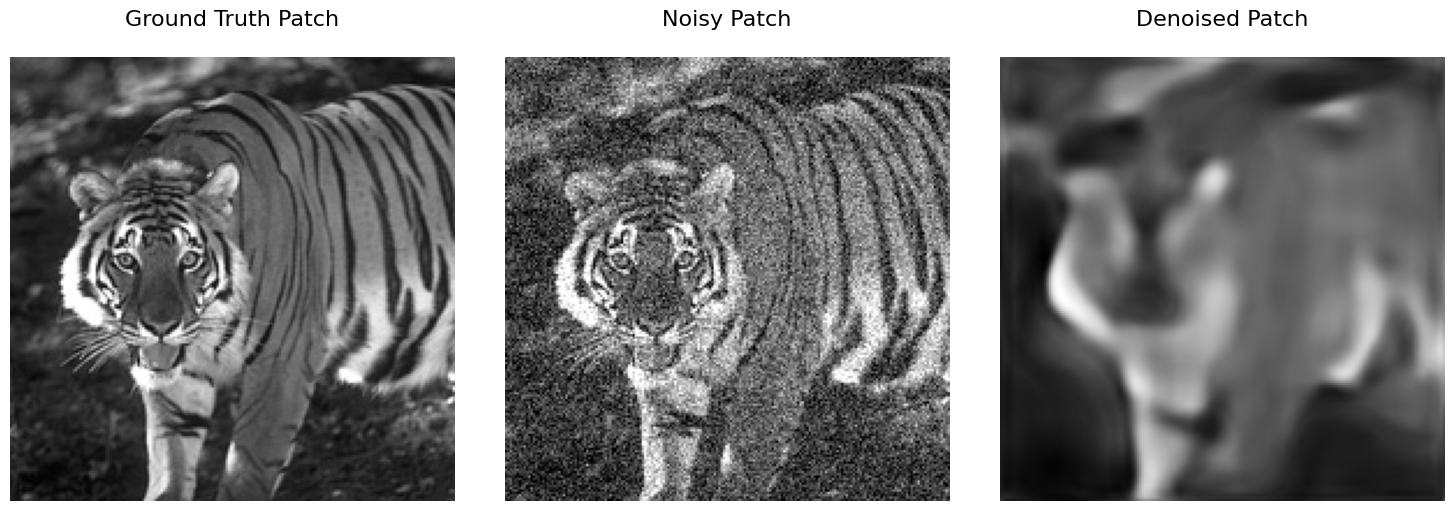

In [21]:
reload(utils)

ground_truth_fig, patches_fig = utils.test_model_on_image(
    image_path=TEST_IMAGE_DIR + "/108005.jpg", 
    model=model,
    patch_size=192, 
    zero_one_normalisation=True, 
    greyscale=True,
    stddev=30,
    patch_coords=(160, 50)
)

ground_truth_fig.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/ground_truth_fig_1.pdf')
patches_fig.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/patches_fig_1.pdf')

# ground_truth_fig.savefig('models/saved/n2n_imagenet10k_05122024/unet/img/ground_truth_fig_1.pdf')
# patches_fig.savefig('models/saved/n2n_imagenet10k_05122024/unet/img/patches_fig_1.pdf')

1/1 [==============================] - 0s 40ms/step


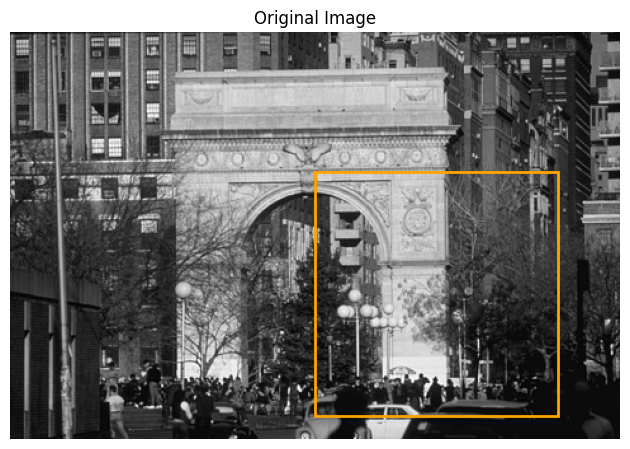

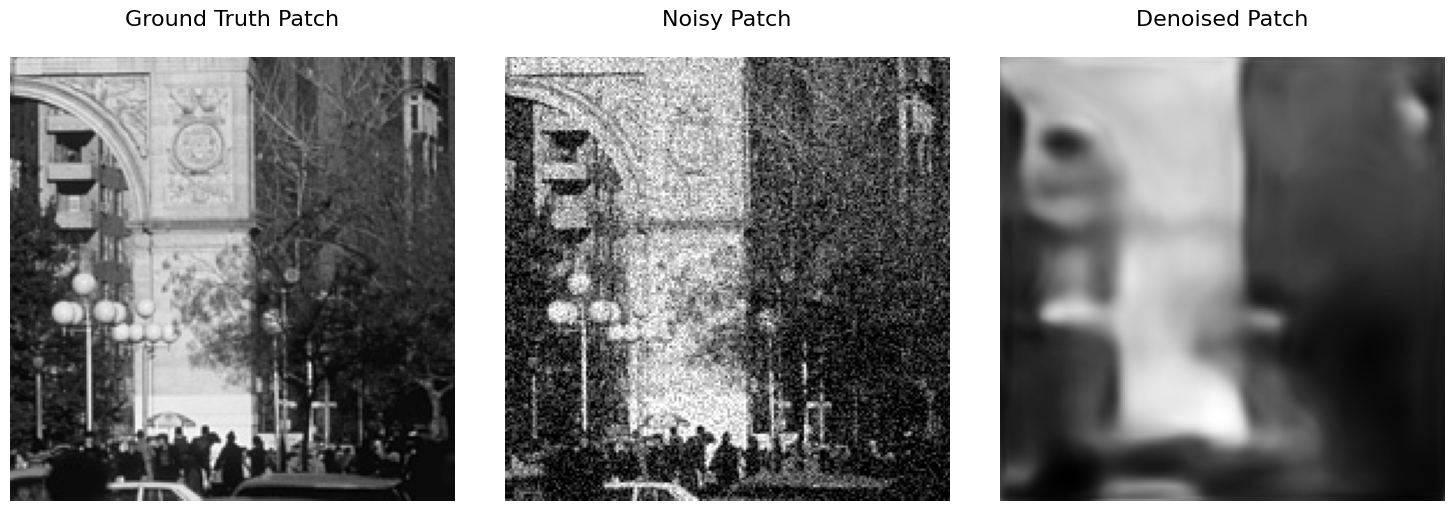

In [20]:
reload(utils)

ground_truth_fig, patches_fig = utils.test_model_on_image(
    image_path=TEST_IMAGE_DIR + "/148089.jpg", 
    model=model,
    patch_size=192, 
    zero_one_normalisation=True, 
    greyscale=True,
    stddev=30,
    patch_coords=(240, 110)
)

ground_truth_fig.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/ground_truth_fig_2.pdf')
patches_fig.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/patches_fig_2.pdf')

# ground_truth_fig.savefig('models/saved/n2n_imagenet10k_05122024/unet/img/ground_truth_fig_2.pdf')
# patches_fig.savefig('models/saved/n2n_imagenet10k_05122024/unet/img/patches_fig_2.pdf')